## Basic setup

In [1]:
%matplotlib inline
%run env_setup.py
from __future__ import division,print_function
from importlib import reload
import numpy as np
import os
from glob import glob
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import lessdeep.utils.display as dis

Using TensorFlow backend.


## Download and setup

**you can change the data and the batch size to fit the model to other datasets**

In [2]:
# Download
from lessdeep.datasets.kaggle import dog_cat
from lessdeep.datasets.kaggle import downloader
reload(dog_cat)

datapath = dog_cat.download_data()

Enter your user name:········
Enter your Password:········
D:\learn\online_course\notes\_data\kaggle\dog_cat\_cache\train.zip already downloaded !
D:\learn\online_course\notes\_data\kaggle\dog_cat\_cache\test1.zip already downloaded !


In [3]:
## setup working data path
path = datapath
sample_path = os.path.join(path, 'sample')

In [4]:
## As large as you can, but no larger than 64 is recommanded
batch_size = 64

## Create model

In [7]:
# Generate vgg model
import lessdeep.model.vgg16
reload(lessdeep.model.vgg16)
from lessdeep.model.vgg16 import Vgg16

vgg = Vgg16()

## Load data(Batches)
- accept data path contain at least two folder
    - train
    - valid
- each subfolder contain images in each folder with the class name

In [8]:
# depends on the variable datapath
batches = vgg.get_batches(os.path.join(datapath, 'train'), batch_size=batch_size,)
                          #generator=ImageDataGenerator(rotation_range=90))
val_batches = vgg.get_batches(os.path.join(datapath, 'valid'), batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
# batches in same order of data folder, for debug purpose
pred_batches = vgg.get_batches(os.path.join(datapath, 'valid'), batch_size=batch_size, shuffle=False)

# get batch labels
def onehot(batch_classes):
    from sklearn.preprocessing import OneHotEncoder
    return np.array(OneHotEncoder().fit_transform(batch_classes.reshape(-1, 1)).todense())

pred_onehot = onehot(pred_batches.classes)

Found 2000 images belonging to 2 classes.


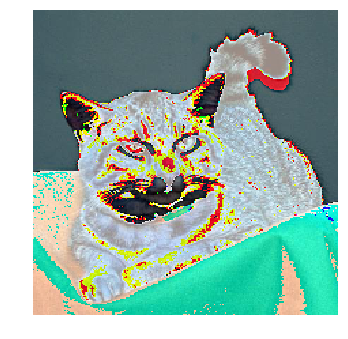

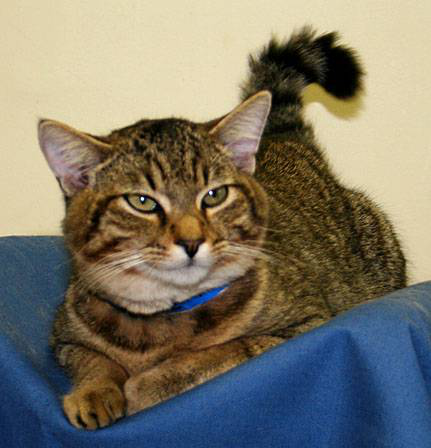

In [10]:
pred_batches.reset()
x, y = pred_batches.next()
x, y = pred_batches.next()
idx=31
dis.imshow([x[idx]])
keras.preprocessing.image.load_img(os.path.join(pred_batches.directory, pred_batches.filenames[32+idx]))

## Finetune

In [11]:
vgg.model.pop()
for layer in vgg.model.layers:
    layer.trainable = False
vgg.model.add(keras.layers.Dense(1000, activation='relu'))
vgg.finetune(batches, method='none')

## Test on sample

In [12]:
smp_batches = vgg.get_batches(os.path.join(sample_path, 'train'), batch_size=batch_size)
smp_val_batches = vgg.get_batches(os.path.join(sample_path, 'valid'), batch_size=batch_size)
smp_imgs, smp_labels = smp_val_batches.next()

Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0787 - acc: 1.0000 - val_loss: 0.3724 - val_acc: 0.8750


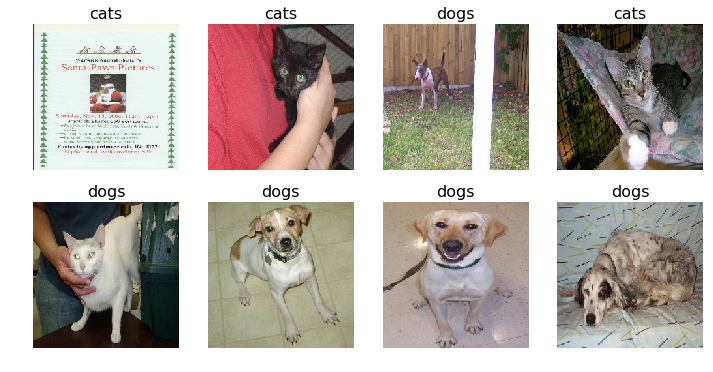

In [14]:
sample_num = 8
sample_epochs = 1

vgg.fit(smp_batches, smp_val_batches, epochs=sample_epochs)

preds, idxs, classes = vgg.predict_data(smp_imgs[:sample_num])
dis.imshow(Vgg16.img_cvt(smp_imgs[:sample_num]), titles=classes[:sample_num], rows=2)

In [ ]:
#vgg.model.compile(keras.optimizers.RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
vgg.load_weights('opt0.h5')
#vgg.compile(lr=0.00001)
keras.backend.set_value(vgg.model.optimizer.lr, 0.0001)
#vgg._default_weight_path('opt0.h5')

## Start train

In [ ]:
epochs = 5
vgg.fit(batches, val_batches, epochs=epochs, workers=4)

In [ ]:
# Then try predict and debug
#remove_predicted_caches(**pred_options)
pred_batches.reset()
probs, preds, classes = vgg.predict(pred_batches, verbose=1)

In [ ]:
vgg.save_weights('opt1.h5')

## Bad result

In [ ]:
reload(dis)
def show_predict(select, shape, **kwargs):
    from keras.preprocessing.image import load_img

    dis.imshow([load_img(os.path.join(pred_batches.directory, pred_batches.filenames[i])) for i in select],
               titles=np.array(probs)[select], rows=shape[0], **kwargs)

def show_random(res, class_idx=None, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    assert res in ['bad', 'good']
    if class_idx is None:
        title = 'Random ' + res
        if res == 'bad':
            idxes = np.where(preds[:num] != pred_batches.classes[:num])[0]
        else:
            idxes = np.where(preds[:num] == pred_batches.classes[:num])[0]
    else:
        title = 'Predicted as {class_name} but is not(in random)'.format(class_name=vgg.classes[class_idx])
        if res == 'bad':
            idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] != 1))[0]
        else:
            idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = np.random.choice(idxes, min(shape[0]*shape[1], len(idxes)), replace=False)
    
    show_predict(select, shape=shape, top_title=title)
    
show_random('bad')
show_random('good')

In [ ]:
show_random('bad', 0)
show_random('bad', 1)

In [ ]:
def show_most_confidence(res, class_idx, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    assert res in ['bad', 'good']
    if res == 'bad':
        title = 'Most confident is {class_name} but not'.format(class_name=vgg.classes[class_idx])
        idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] != 1))[0]
    else:
        title = 'Most confident is {class_name} and it is '.format(class_name=vgg.classes[class_idx])
        idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = idxes[np.argsort(np.array(probs)[idxes])[::-1][:min(shape[0]*shape[1], len(idxes))]]
    
    show_predict(select, shape=shape, top_title=title)
show_most_confidence('bad', 1)
show_most_confidence('good', 1)

## Most uncertain

In [ ]:
def show_most_uncertain(class_idx, shape=(2, 4)):
    num = min(len(preds), len(pred_onehot))
    title = 'Most uncirtain is {class_name} and it is '.format(class_name=vgg.classes[class_idx])
    idxes = np.where((preds[:num] == class_idx) & (pred_onehot[:num, class_idx] == 1))[0]
    select = idxes[np.argsort(np.array(probs)[idxes])[:min(shape[0]*shape[1], len(idxes))]]

    show_predict(select, shape=shape, top_title=title)
show_most_uncertain(0)
show_most_uncertain(1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_batches.classes[:len(preds)], preds)
print(cm)

# Submit reuslt

In [ ]:
test_batches = vgg.get_batches(os.path.join(datapath, 'test'), batch_size=batch_size, shuffle=False)
steps = int(np.ceil(test_batches.samples / test_batches.batch_size))
test_preds = vgg.model.predict_generator(test_batches, steps=steps, verbose=1)[:test_batches.samples]

In [ ]:
def save_test(class_idx, clip=0.02):
    import csv
    file = os.path.join('_cache', 'submit.csv')
    with open(file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['id', 'label'])
        clipped = np.clip(test_preds, clip, 1-clip)
        for i, pred in enumerate(clipped):
            source_name = os.path.basename(test_batches.filenames[i])
            writer.writerow([os.path.splitext(source_name)[0], pred[class_idx]])
    return file
from IPython.display import FileLink
FileLink(save_test(class_idx=1), )